# Ray tracing in a Realistic Context: Nazare's Canyon

In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import xarray as xr
import matplotlib.pyplot as plt

from PIL import Image
import requests
from io import BytesIO

import mantaray

from src import *

# Introduction

This notebook test the Ray Tracing Package in a realistic analysis with a realistic bathymetry and a null current field. Both fields are already constructed but can be re-constructed by the use of the present notebook. Before running this example, it is recommended that users run idealized_fields.ipynb first

**Initialization**:

- Optical cata are from the sentinel-2 satellite available at: https://browser.dataspace.copernicus.eu. High resolution bathymetry data are from the European Commission ans are available free of charge. (https://emodnet.ec.europa.eu/)
  
- The initial conditions (wave wavelength/period/wavenumber, and direction) for the present example are obtained from spectral analysis of Sentinel-2 image. The spectrum is stored in the spec_s2.nc file.

- num_rays: is the number of rays shot. All rays have the same initial parameters

- The flags plot_spectrum, plot_bathy are for the users if they want to vizualize in details the wave spectrum from the Sentinel-2 image and the bathymetry.

- x$_{0}$, y$_{0}$: are the locations where the rays are shot

In [2]:
num_rays = 100  # Number of points to sample along the line (// number of rays)
plot_spectrum = True
plot_bathy = True

### Load Sentinel-2 spectrum, brightness, and bathymetry data

In [3]:
#########
# the Sentinel 2 spectrum
##########
ds_spec_sentinel2 = xr.open_dataset('../data/spec_s2.nc')
ds_spec_sentinel2 = ds_spec_sentinel2.sel(wavenumber =slice(0, 0.025)) # focus on the swell band

#########
# Sentinel 2 image
##########
ds_nazare = xr.open_dataset('../data/s2_image.nc')

#########
# Nazare Bathy
##########
ds_nazare_depth = xr.open_dataset('../data/nazare_bathy.nc')
variables = ['value_count', 'elevation']
ds_nazare_depth = ds_nazare_depth[variables]


##### Meter axes for the ray tracing: the ray tracing package deals with axes in meters and not with longitude/latitude

In [4]:

mean_lat = np.nanmean(ds_nazare_depth.latitude.values) # the mean latitude in the domain
delta_lon = abs(np.nanmean(np.diff(ds_nazare_depth.longitude)))
delta_lat = abs(np.nanmean(np.diff(ds_nazare_depth.latitude)))

dx_nazare_depth, dy_nazare_depth = decimal_coords_to_meters(delta_lon, delta_lat, mean_lat) # get the distance between two neighbouring pixels


##########
# --- Longitude and Latitude degree steps
##########
nx = len(ds_nazare.longitude.values)
ny = len(ds_nazare.latitude.values)
dlon = (ds_nazare.longitude.max().values - ds_nazare.longitude.min().values)/nx
dlat = (ds_nazare.latitude.max().values - ds_nazare.latitude.min().values)/ny

##########
# --- Longitude and Latitude meter steps -- for plot
##########
dx_sentinel_2 = 10 # this is from the sensor's parameter (/!\ don't change it /!\)
sub_s2_dist_x =(ds_nazare.longitude.size)*dx_sentinel_2
sub_s2_dist_y =(ds_nazare.latitude.size)*dx_sentinel_2

lon_meter_nazare_S2 = np.arange(0, sub_s2_dist_x, dx_sentinel_2)
lat_meter_nazare_S2 = np.arange(sub_s2_dist_y, 0, -dx_sentinel_2)


lon_meter_nazare_depth = np.arange(0, len(ds_nazare_depth.longitude.values)*dx_nazare_depth, dx_nazare_depth)
lat_meter_nazare_depth = np.arange(0, len(ds_nazare_depth.latitude.values) * dy_nazare_depth, dy_nazare_depth)


##### Create the bathymetry file for the ray tracing (not mandatory because already created)

In [5]:
output_file_cur = "../data/current_nazare.nc"
output_file_depth = "../data/bathy_nazare_edited_bis.nc"

create_depth_forcing(lon_meter_nazare_depth, lat_meter_nazare_depth, ds_nazare_depth.elevation.values * (-1), output_file_cur, output_file_depth, ucur = 0, vcur = 0)

##### Vizualize the bathymetry: Superimpose the sentinel-2 image

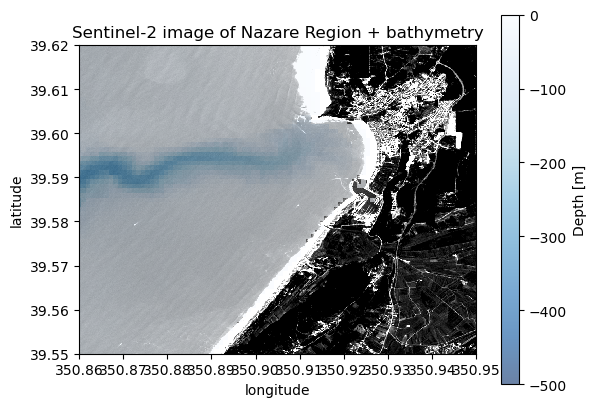

In [6]:
if plot_bathy:
    sub_nazare_S2fig, ax = plt.subplots()
    ds_nazare.brightness.plot(vmin = 200, vmax = 1000, cmap = 'binary_r', add_colorbar = False)
    p2 = ax.pcolormesh(ds_nazare_depth.longitude+360, ds_nazare_depth.latitude, ds_nazare_depth.elevation, vmin = -500, vmax = 0, alpha = .6, cmap = 'Blues_r')
    cbar = plt.colorbar(p2)
    cbar.ax.set_ylabel('Depth [m]')
    ax.set_xlim([350.86, 350.95])
    ax.set_ylim([39.55, 39.62])
    ax.set_aspect('equal', 'box')
    ax.set_title('Sentinel-2 image of Nazare Region + bathymetry')

##### Define the initial location of rays. Instead of shotting rays from the edges of the domain, we create a dummy line that will be used to defined starting points ($x_{0}$, $y_{0}$)

In [7]:
ds_depth_meter = xr.open_dataset("../data/bathy_nazare_edited_bis.nc")

#########
# --- The starting line for ray_tracing
#########
x_line = [45_000, 50_000]
y_line = [37_000, 40_000]

x_line_param = np.linspace(x_line[0], x_line[1], num_rays)
y_line_param = np.linspace(y_line[0], y_line[1], num_rays)

#########
# --- Loop through the points along the started line and find the closest pixels
######### 
x0 = []
y0 = []
depth0 = []
XX, YY = np.meshgrid(ds_depth_meter.x.values, ds_depth_meter.y.values)
for x, y in zip(x_line_param, y_line_param):
    x_closest, y_closest, depth_closest = find_closest_pixel_depth(x, y, XX, YY,ds_depth_meter.depth.values)

    x0.append(float(x_closest))
    y0.append(float(y_closest))
    depth0.append(float(depth_closest))

The incident wave direction is 307.50 deg and the wavelength is 334.45 m (T = 14.64 sec)


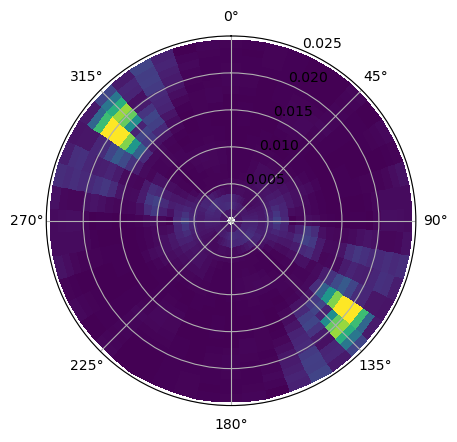

In [15]:
if plot_spectrum:
    fig, ax = plt.subplots(subplot_kw = {'projection':'polar'})
    ax.pcolormesh(ds_spec_sentinel2.directions, ds_spec_sentinel2.wavenumber, ds_spec_sentinel2.wave_directional_spectrum.T, vmin = 0, vmax = 2000)
    ax.set_ylim([0, .025])
    ax.set_theta_offset(np.pi/2) # shift the 0 to the nroth
    ax.set_theta_direction(-1) # swap the direction (clockwise)
    
iddir, id_wn = np.where(ds_spec_sentinel2.wave_directional_spectrum.values == ds_spec_sentinel2.wave_directional_spectrum.values.max())
dp_spec = ds_spec_sentinel2.directions[iddir].values[0]*180/np.pi + 180 # swell cannot be from the coast (verified with the phase-difference spectrum)
lambda_p = (2*np.pi)/ds_spec_sentinel2.wavenumber[id_wn].values[0]

sigma = (g*ds_spec_sentinel2.wavenumber[id_wn].values[0])**(1/2)# intrinsic frequency
f = sigma/(2*np.pi)
T0 = 1/(f)
print(f'The incident wave direction is {dp_spec:.2f} deg and the wavelength is {lambda_p:.2f} m (T = {T0:.2f} sec)' )


##### Setting up the ray tracing with all the informations provided above

In [16]:
###########
# ---  Initial Wave Conditions
###########

k = 2*np.pi/lambda_p
depth = np.mean(depth0)
f = frequency_from_wavelength(lambda_p, depth)
cg = group_velocity(k, f, depth)
# Period of incident waves in seconds
T0 = 1/f
theta0 = dp_spec * np.pi/180
# Convert period to wavenumber magnitude
k0 = 2*np.pi/lambda_p

# Calculate wavenumber components
kx0 = k0*np.cos(theta0)
ky0 = k0*np.sin(theta0)


# Initialize wavenumber for all rays
Kx0 = kx0*np.ones(num_rays)
Ky0 = ky0*np.ones(num_rays)

# Current and bathymetry file path
current = output_file_cur
bathymetry = output_file_depth # note that the variable names have to be x, y, u, v, depth

# Read x and y from file to get domain size
ds = xr.open_dataset(bathymetry)

# Estimates CFL
# Computes grid smallest spacing
dd = np.min([np.diff(ds.x).mean(), np.diff(ds.y).mean()])
# Computes group velocity in intermediate water
cg = group_velocity(k0, f, depth)
# Computes CFL
cfl = dd/cg

duration = round(x.max()/cg)
step_size = cfl

In [17]:
bando = mantaray.ray_tracing(x0, y0, Kx0, Ky0, duration, step_size, bathymetry, current) # Ray Tracing

##### Plot: in this plot we represent the wave rays based on the initial conditions provided previously in the notebook. One panel display the regional domain, another display a zoom around the Nazare's peninsula. The wave spectrum computed from the Sentinel-2 image is provided in the plot. As an illustration of the waves from the coast, a picture taken from a photograph on the cliff for the day studied day is displayed.

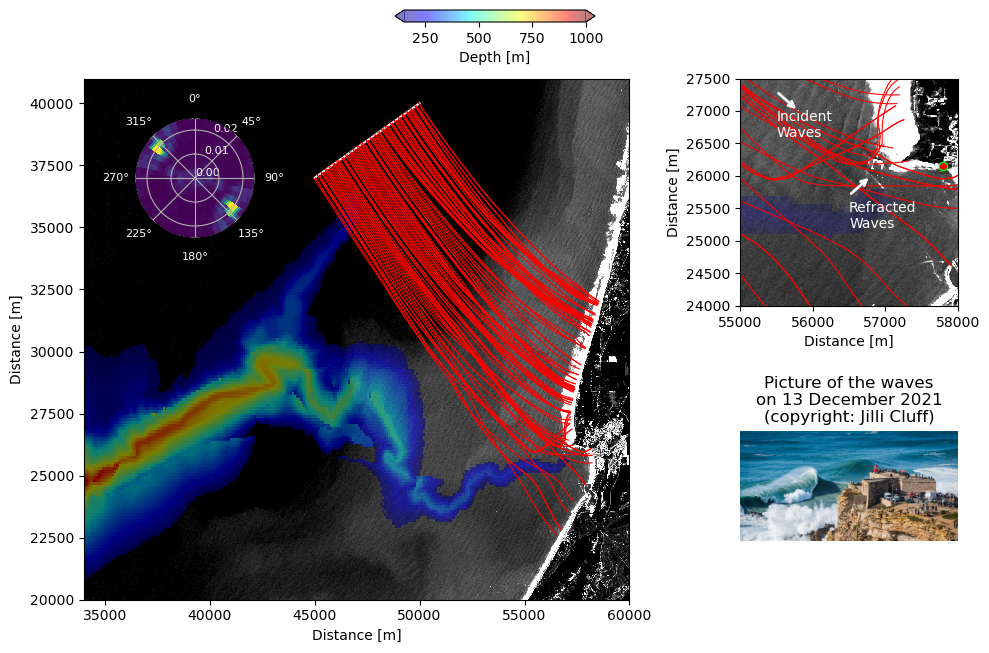

In [18]:
# --- For a beautiful plot, mask shallow waters
masked_depth = np.ma.masked_where(ds.depth.values<150, ds.depth.values)

fig = plt.figure(figsize=(10, 6))  # Adjust size as needed

# Define the grid dimensions and add subplots
ax1 = plt.subplot2grid((2, 3), (0, 0), rowspan=2, colspan=2)  # Large panel on the left
ax2 = plt.subplot2grid((2, 3), (0, 2))                       # Top-right panel
ax3 = plt.subplot2grid((2, 3), (1, 2))   

ax_inset = fig.add_axes([.1, .7, .2, .2], projection = 'polar')

# --- Plot the wave directional spectrum
ax_inset.pcolormesh(ds_spec_sentinel2.directions, ds_spec_sentinel2.wavenumber, ds_spec_sentinel2.wave_directional_spectrum.T, vmin = 0, vmax = 2000)
ax_inset.set_ylim([0, .025])
ax_inset.set_theta_offset(np.pi/2) # shift the 0 to the nroth
ax_inset.set_theta_direction(-1) # swap the direction (clockwise)
ax_inset.tick_params(axis='both', which='both', colors='white', labelsize=8)
ax_inset.set_yticks([0, .01, .02])

# --- Plot the brightness observed by Sentinel-2 (panel (1))
ax1.pcolormesh(lon_meter_nazare_S2, lat_meter_nazare_S2, ds_nazare.brightness,\
              vmin = 200, vmax = 1000, cmap = 'binary_r')
cs = ax1.pcolormesh(lon_meter_nazare_depth, lat_meter_nazare_depth, masked_depth, cmap = 'jet', vmin = 150, vmax = 1000, alpha = .5)
cax = fig.add_axes([.4, 1.06, 0.2, 0.02])
cbar = plt.colorbar(cs, cax = cax, orientation = 'horizontal', extend = 'both')
cbar.ax.set_xlabel('Depth [m]')
ax1.plot(x_line, y_line, color = 'w')

# --- Plot rays (panel (1))
for i in range(bando.ray.size)[:]:
    ray = bando.isel(ray=i)
    ax1.plot(ray.x, ray.y, 'r', lw=.78)

ax1.set_xlim([34_000, 60_000])
ax1.set_ylim([20_000, 41_000])
ax1.set_xlabel('Distance [m]')
ax1.set_ylabel('Distance [m]')

# --- Plot the brightness observed by Sentinel-2 (panel (2))

cs = ax2.pcolormesh(ds_depth_meter.x, ds_depth_meter.y, ds_depth_meter.depth)
ax2.pcolormesh(lon_meter_nazare_S2, lat_meter_nazare_S2, ds_nazare.brightness,\
              vmin = 200, vmax = 1000, cmap = 'binary_r')
ax2.pcolormesh(lon_meter_nazare_depth, lat_meter_nazare_depth, masked_depth, cmap = 'jet', vmin = 150, vmax = 1000, alpha = .2)

start_inc = (55_500, 27_300)
end_inc = (55_800, 27_000)

start_ref = (56_500, 25_700)
end_ref = (56_800, 26_000)

ax2.annotate(
    '',  # No text
    xy=end_ref,  # End of the arrow
    xytext=start_ref,  # Start of the arrow
    arrowprops=dict(facecolor='white', edgecolor = 'white', arrowstyle='->', lw=2)  # Arrow properties
)
ax2.annotate(
    '',  # No text
    xy=end_inc,  # End of the arrow
    xytext=start_inc,  # Start of the arrow
    arrowprops=dict(facecolor='white', edgecolor = 'white', arrowstyle='->', lw=2)  # Arrow properties
)

ax2.text(56_500, 25_200, 'Refracted\nWaves', color = 'w')
ax2.text(55_500, 26_600, 'Incident\nWaves', color = 'w')
ax2.plot(57_800, 26_150, marker = 'o', markersize = 6,  color = 'lime')
ax2.plot(57_800, 26_150, marker = 'o', markersize = 4,  color = 'r')

# --- Plot rays (panel (2))
for i in range(bando.ray.size)[:]:
    ray = bando.isel(ray=i)
    ax2.plot(ray.x, ray.y, 'r', lw=.78)

ax2.set_xlim([55_000, 58_000])
ax2.set_ylim([24_000, 27_500])
ax2.set_xlabel('Distance [m]')
ax2.set_ylabel('Distance [m]')

# --- Plot(panel (3))
# URL of the image
url = "https://s3.amazonaws.com/www.explorersweb.com/wp-content/uploads/2021/12/14183820/hero-View-across-the-Fort-Nazare-lighthouse-Photo-RM-Nunes-via-Shutterstock.jpg"

# Fetch and load the image from the URL
response = requests.get(url)
img = Image.open(BytesIO(response.content))
ax3.imshow(img)  # Display the image in this panel
ax3.axis("off")  # Turn off axes for the image panel
ax3.set_title('Picture of the waves\non 13 December 2021\n(copyright: Jilli Cluff)')
plt.tight_layout()